#### Подключаем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Указываем пути к директориям

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'r_husnullin_predictions.csv'

#### Загружаем датасет

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


#### Приведение типов

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [8]:
train_df['Id'] = train_df['Id'].astype(str)

#### Обзор целевой переменной

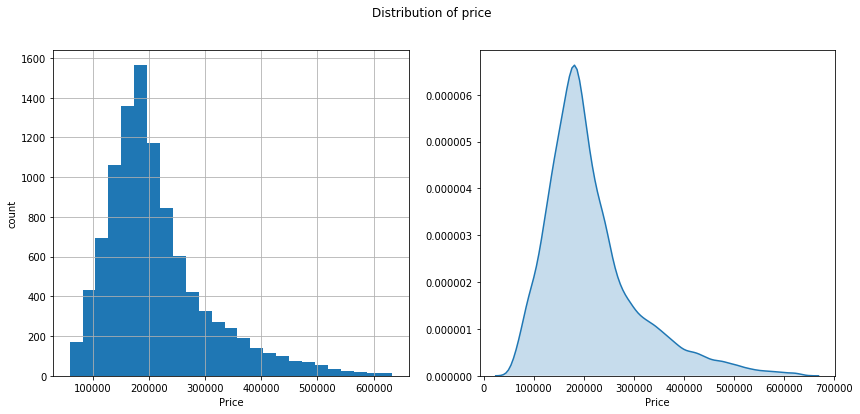

In [9]:
plt.figure(figsize = (14, 6))

plt.subplot(121)
train_df['Price'].hist(bins=25)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of price')
plt.show()

In [10]:
# По графику целевой переменной не видно сильно заметных выбросов. Рассмотрим количественные переменные.

#### Количественные переменные

In [11]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [12]:
# По максимальным и минимальным значениям видим ярко выраженные выбросы в некоторых категориях, а так же пропуски в строках.

#### Обработка пропусков

In [13]:
train_df.isnull().sum(axis=0)

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [14]:
# Заполним пропуски медианой и сделаем проверку

In [15]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

In [16]:
train_df['LifeSquare'].isnull().sum()

0

In [17]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [18]:
train_df['Healthcare_1'].isnull().sum()

0

In [19]:
train_df.isnull().sum(axis=0)

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

#### Обработка выбросов

In [20]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [21]:
# Для квартир с показателем площади < 15 добавим 10. В реальности средняя минимальная площадь квартиры примерно равна 20-25 м2.

In [22]:
train_df[train_df['Square'] <= 15].tail(n=10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,900.0,0,1,B,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,900.0,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,181434.825589
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,900.0,1,11,B,458378.777006
9294,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,900.0,3,2,B,438005.182323
9613,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083


In [23]:
train_df.loc[train_df['Square'] <= 15, 'Square'] = train_df.loc[train_df['Square'] <=15, 'Square'] + 15

In [24]:
train_df[train_df['Square'] <= 15]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [25]:
# Ниже видим достаточно большой кусок данных, где жилая площидь меньше 10 м2, что не соответствует реальности.

In [26]:
train_df[train_df['LifeSquare'] <= 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,900.0,0,0,A,337299.867936
95,4280,34,2.0,61.334968,4.091945,1.0,26,1.0,2014,0.069753,B,B,53,13670,4,900.0,1,11,B,286564.441972
134,12613,6,2.0,65.496674,5.589324,1.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.643541
158,16779,27,3.0,51.991064,4.896202,1.0,22,25.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,174687.566186
160,3522,6,1.0,66.419841,3.987101,1.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.229815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,13583,27,2.0,58.943039,3.319486,1.0,11,17.0,2017,0.011654,B,B,4,915,0,900.0,0,0,B,142789.948977
9813,2040,62,1.0,122.438148,5.751401,1.0,2,3.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,224900.897679
9828,13630,24,3.0,127.141143,4.811405,1.0,3,1.0,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.912034
9888,6053,6,1.0,41.314775,5.005477,1.0,9,17.0,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,159149.515475


In [27]:
train_df.loc[train_df['LifeSquare'] <= 10, 'LifeSquare'] = train_df.loc[train_df['LifeSquare'] <=10, 'Square'] + 10

In [28]:
train_df[train_df['LifeSquare'] <= 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [29]:
# Ниже видим не характерные столбцы с отрицательными или нулевыми значениями.

In [30]:
# DiscrictId. В этой выборке видим большую часть одинаковых показателей Healthcare_1. 
# ID района, где так же большая часть Healthcare_1 = 2857, равен 147 ( Проверил в соседней вкладке, на черновике )
# Вероятнее всего данные ID для нашей выборки не заполнились ошибочно. Укажем ID = 147 в ручную.

In [31]:
train_df[train_df['DistrictId'] <= 0].tail(n=10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9459,6032,0,2.0,57.425911,31.404044,10.0,11,16.0,1984,0.319809,B,B,25,4756,16,2857.0,5,8,B,235450.619464
9507,11508,0,2.0,53.133226,32.030492,11.0,10,16.0,1984,0.319809,B,B,25,4756,16,2857.0,5,8,B,244900.250309
9516,14236,0,1.0,19.927423,15.541536,0.0,2,5.0,1962,0.319809,B,B,25,4756,16,2857.0,5,8,B,102395.788856
9517,9550,0,1.0,35.415956,22.559333,5.0,9,9.0,1967,0.319809,B,B,25,4756,16,2857.0,5,8,B,142172.907136
9542,5193,0,2.0,80.702341,45.332859,11.0,5,21.0,2013,0.006076,B,B,30,5285,0,645.0,6,6,B,184164.435484
9701,9022,0,2.0,60.789975,32.781260,1.0,4,17.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,162985.116572
9840,2484,0,3.0,70.322746,45.465960,10.0,8,12.0,1976,0.319809,B,B,25,4756,16,2857.0,5,8,B,308098.189977
9876,1975,0,1.0,34.890672,18.788704,6.0,6,8.0,1962,0.319809,B,B,25,4756,16,2857.0,5,8,B,176394.968051
9921,11426,0,2.0,56.724377,32.602235,8.0,9,12.0,1982,0.006076,B,B,30,5285,0,645.0,6,6,B,164687.824957
9959,10361,0,1.0,32.416925,19.257869,6.0,6,5.0,1963,0.319809,B,B,25,4756,16,2857.0,5,8,B,125579.315184


In [32]:
train_df.loc[train_df['DistrictId'] <= 0, 'DistrictId'] = train_df.loc[train_df['DistrictId'] <=0, 'DistrictId'] + 147

In [33]:
train_df[train_df['DistrictId'] <= 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [34]:
# Следующий этап

In [35]:
# Показатель комнат равен 0.

In [36]:
train_df[train_df['Rooms'] <= 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,900.0,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,32.781260,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,98129.976788
3911,770,28,0.0,49.483501,32.781260,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,32.781260,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,17.377248,27.377248,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,900.0,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,219281.918007


In [37]:
# Видим, что квартиры в данной выборке имеют достаточно большую плошадь. В реальности это как минимум 3 комнаты.

In [38]:
train_df.loc[train_df.Rooms <= 0, 'Rooms'] = set(train_df.loc[train_df.Rooms == 3, 'Rooms'].values)

In [39]:
train_df[train_df['Rooms'] <= 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [40]:
# Следующий этап

In [41]:
# Ниже имеем большой кусок данных, где значение этажа больше самого количества этажей
# Как вариант заменить значение HouseFloor на Floor, тем самым сделаем этажи последними
# В реальности это будет соответствовать количеству этажей в доме

In [42]:
train_df[train_df['HouseFloor'] < train_df['Floor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,32.781260,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,221244.156664
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,900.0,0,0,B,117000.381287
21,11935,27,2.0,64.711835,32.781260,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,127200.026511
23,6641,54,3.0,118.907612,32.781260,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074977,47.633428,6.0,11,9.0,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.880156
9985,16159,27,1.0,38.968338,32.781260,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,95529.569405
9989,4145,96,3.0,90.055233,47.860231,11.0,26,24.0,2005,0.041116,B,B,53,14892,4,900.0,1,4,B,441108.911237
9991,11553,3,3.0,101.622794,51.628780,12.0,18,17.0,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.501504


In [43]:
train_df.loc[train_df.HouseFloor < train_df.Floor, 'HouseFloor'] = train_df.loc[train_df.HouseFloor < train_df.Floor, 'Floor']

In [44]:
train_df[train_df['HouseFloor'] < train_df['Floor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [45]:
# Следующий этап

In [46]:
# Ниже пример из 718 строк, где жилая площадь больше самой пощади квартиры. Разница между значениями не большая.
# Возможно будет смысл поменять местами данные для этих 718 строк

In [47]:
train_df[train_df['Square'] < train_df['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958871,116.958871,0.0,17,17.0,2018,0.072158,B,B,2,629,1,900.0,0,0,A,337299.867936
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,900.0,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,20.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,900.0,0,1,B,199215.452229
95,4280,34,2.0,61.334968,71.334968,1.0,26,26.0,2014,0.069753,B,B,53,13670,4,900.0,1,11,B,286564.441972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,B,B,2,469,0,900.0,0,0,B,234194.837047
9902,14001,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,900.0,1,4,B,528560.506016
9954,583,27,3.0,84.250710,94.250710,1.0,15,15.0,2016,0.072158,B,B,2,629,1,900.0,0,0,A,236647.781363


In [48]:
train_df.loc[train_df.Square < train_df.LifeSquare, ['Square','LifeSquare']]=train_df.loc[train_df.Square < train_df.LifeSquare, ['LifeSquare','Square']].values

In [49]:
train_df[train_df['Square'] < train_df['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [50]:
# Следующий этап

In [51]:
# Ниже кусок датасета, где площадь кухни больше площади самой квартиры.
# Поменяем местами значения столбцов, картина будет более реальная.

In [52]:
train_df[train_df['Square'] < train_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,4.0,2014,0.072158,B,B,2,629,1,900.0,0,0,A,108337.484207
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,900.0,1,0,B,160488.033165
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,900.0,0,0,B,99079.960518
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,6.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275


In [53]:
train_df.loc[train_df.Square < train_df.KitchenSquare, ['Square','KitchenSquare']]=train_df.loc[train_df.Square < train_df.KitchenSquare, ['KitchenSquare','Square']].values

In [54]:
train_df[train_df['Square'] < train_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [55]:
# Следующий этап

In [56]:
# Выведем данные с плошадью больше 1000

In [57]:
train_df[train_df['Square'] > 1000]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,2014.000000,46.447960,47.100719,4,4.0,2014,0.072158,B,B,2,629,1,900.0,0,0,A,108337.484207
4328,16550,27,3.0,7480.592129,81.694417,1.000000,9,17.0,2016,0.017647,B,B,2,469,0,900.0,0,0,B,217357.492366
8584,14679,81,1.0,1970.000000,19.278394,32.276663,6,6.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275


In [58]:
# Вероятнее всего нужно убрать один 0.

In [59]:
train_df.loc[train_df['Square'] > 1000, 'Square'] = train_df.loc[train_df['Square'] > 1000, 'Square'] / 100

In [60]:
train_df[train_df['Square'] > 1000]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [61]:
# Следующий этап

In [62]:
# Выведем строки, в которых сумма жилой площади и кухни больше площади самой квартиры

In [63]:
train_df[train_df.KitchenSquare + train_df.LifeSquare > train_df.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,B,B,2,475,0,900.0,0,0,B,96029.167877
69,6925,27,2.0,64.929103,63.304605,10.0,15,17.0,2016,0.072158,B,B,2,629,1,900.0,0,0,A,228584.001072
129,6072,6,1.0,65.102017,64.622603,1.0,10,10.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,175899.978284
136,6172,27,2.0,92.400007,92.069236,10.0,2,5.0,1977,0.075424,B,B,11,3097,0,900.0,0,0,B,116942.671045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897,4497,1,1.0,38.330353,38.010046,8.0,7,17.0,1991,0.025609,B,B,33,5261,0,240.0,3,1,B,97464.327338
9902,14001,73,1.0,44.267551,44.098768,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161
9910,16568,27,4.0,201.627361,200.334539,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,900.0,1,4,B,528560.506016
9918,14904,34,4.0,104.049130,99.788387,10.0,8,25.0,2018,0.069753,B,B,53,13670,4,900.0,1,11,B,411971.106869


In [64]:
train_df.loc[train_df.KitchenSquare + train_df.LifeSquare > train_df.Square, 'Square'] = train_df.loc[train_df.KitchenSquare + train_df.LifeSquare > train_df.Square, 'Square'] + 125

In [65]:
train_df[train_df.KitchenSquare + train_df.LifeSquare > train_df.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [66]:
# Следующий этап

In [67]:
# Проверим выбросы, где год постройки больше 2020

In [68]:
train_df[train_df.HouseYear > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [69]:
train_df.loc[train_df.HouseYear > 2020, 'HouseYear'] = set(train_df.loc[train_df.HouseYear == 2020, 'HouseYear'].values)

In [70]:
train_df[train_df.HouseYear > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [71]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,51.106400,1.892900,64.579216,36.474186,5.874767,8.526700,13.435700,1984.872400,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.954307,0.838391,37.676212,17.164497,5.114429,5.241148,6.094012,18.416347,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,1.000000,1.000000,17.498542,10.523868,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,21.000000,1.000000,42.452386,27.565049,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,37.000000,2.000000,54.649565,32.781260,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,77.000000,2.000000,71.365977,42.318819,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,766.065193,638.163193,123.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [72]:
# Проверим зависимость цены от ID района

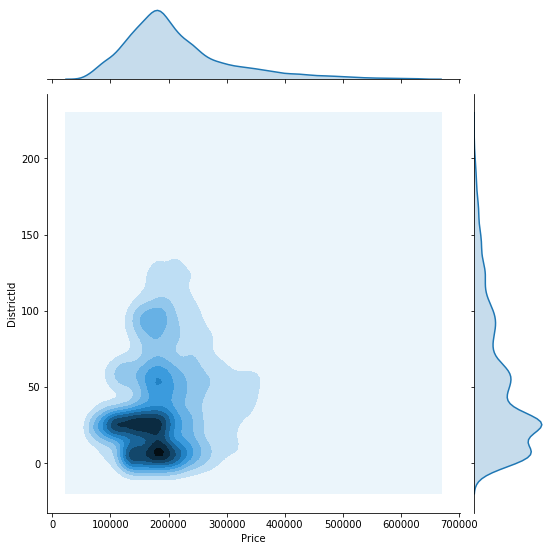

In [73]:
grid = sns.jointplot(train_df['Price'], train_df['DistrictId'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [74]:
# По графику видим два района, в которых сосредоточено большинство квартир

#### Создание новых признаков

In [75]:
# Средняя цена по району

In [76]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [77]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,1,1.0,146735.671740
1,1,2.0,202706.090239
2,1,3.0,244005.272380
3,1,4.0,277290.705058
4,1,19.0,78364.616704


In [78]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,900.0,0,11,B,184966.930730,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,263206.223152
3,5809,58,2.0,178.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,158539.052715


In [79]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [80]:
test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          3959 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        2623 non-null   float64
 16  Helthc

#### Категориальные признаки

In [81]:
df_obj_ft = train_df.select_dtypes(include='object')
df_obj_ft.head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,14038,35,B,B,B
1,15053,41,B,B,B
2,4765,53,B,B,B
3,5809,58,B,B,B
4,10783,99,B,B,B


In [82]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [83]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.930730,207786.135836,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.908524,263206.223152,1,1,1
3,5809,58,2.0,178.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,166809.665642,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,158539.052715,1,1,1


#### Отбор признаков

In [84]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'MedPriceByDistrict',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin']

In [85]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Shops_1', 'MedPriceByDistrict', 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin']

target_name = 'Price'

In [86]:
train_df.shape

(10000, 24)

In [87]:
test_df.shape

(5000, 19)

#### Разобьем данные на train и test

In [88]:
X = train_df[feature_names]
y = train_df[target_name]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

#### Строим модель

In [90]:
# Обучение

In [91]:
X_train.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Shops_1', 'MedPriceByDistrict', 'Ecology_2_bin',
       'Ecology_3_bin', 'Shops_2_bin'],
      dtype='object')

In [92]:
X_train.isnull().sum()

Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Shops_1               0
MedPriceByDistrict    0
Ecology_2_bin         0
Ecology_3_bin         0
Shops_2_bin           0
dtype: int64

In [93]:
rf_model = RandomForestRegressor(max_depth=8, n_estimators=20, random_state=200)
rf_model.fit(X_train.fillna(-9999), y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=200, verbose=0, warm_start=False)

In [94]:
# Отложенная выборка

In [95]:
def preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.826
Test R2:	0.723


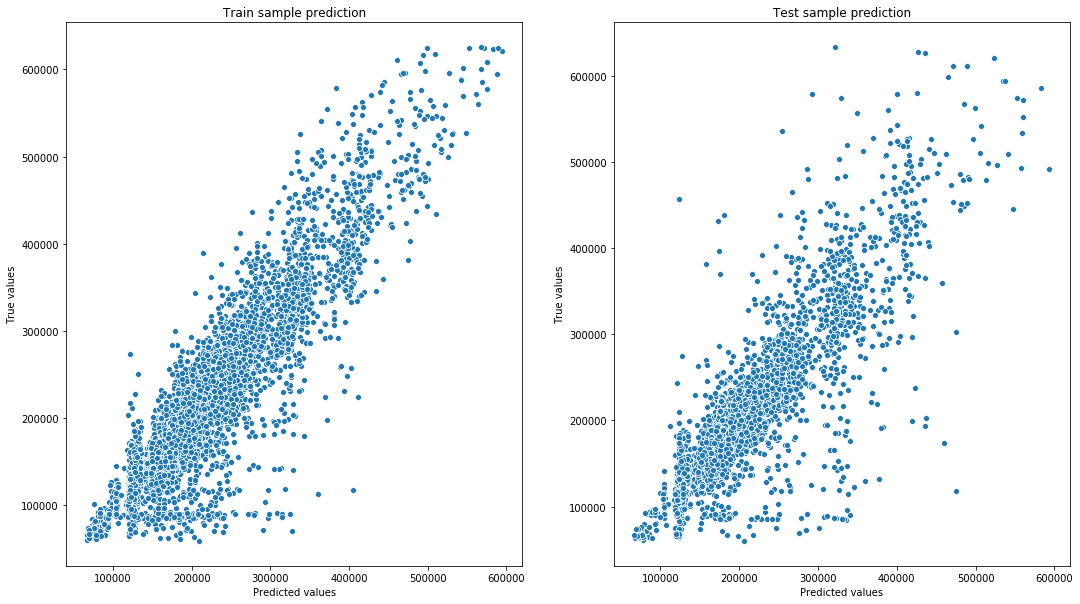

In [96]:
y_train_preds = rf_model.predict(X_train.fillna(-9999))
y_test_preds = rf_model.predict(X_test)

preds(y_train, y_train_preds, y_test, y_test_preds)

#### Кросс валидация

In [97]:
from sklearn.model_selection import StratifiedKFold

In [98]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=5)
)
cv_score

array([0.73433523, 0.71313485, 0.72464869, 0.71359364, 0.74125418])

In [99]:
cv_score.mean(), cv_score.std()

(0.7253933195009855, 0.011149723563802963)

In [100]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7142435959371826, 0.7365430430647885)

#### Важность признаков

In [101]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
13,MedPriceByDistrict,0.729491
1,Square,0.096638
3,KitchenSquare,0.028810
5,HouseFloor,0.028782
10,Social_3,0.023047
2,LifeSquare,0.016427
6,HouseYear,0.015433
9,Social_2,0.013432
4,Floor,0.012504
11,Healthcare_1,0.010795


#### Сохраняем предсказания в csv файл

In [102]:
pd.DataFrame(y_test_preds).to_csv(TEST_DATASET_EXT_PATH, index=False)